In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 8
epochs = 20
num_workers = 2
learning_rate = 3e-3

In [4]:
in_channels = 3
out_channels = 1
features = 32
image_height = 572
image_width = 572
mask_height = 388
mask_width = 388

In [5]:
def save_checkpoint(epoch, model, optimizer, t_loss, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    torch.save({
        'epoch' : epoch,
        't_loss' : t_loss,
        'model' : model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }, checkpoint)
    print(f'Checkpoint Saved at epoch{epoch+1}')

def load_checkpoint(model, optimizer, root_dir):
    checkpoint = os.path.join(root_dir, 'checkpoint.pt')
    if os.path.exists(checkpoint):
        checkpoint_file = torch.load(checkpoint)
        epochs = checkpoint_file['epoch']
        t_loss = checkpoint_file['t_loss']
        model = model.load_state_dict(checkpoint_file['model'])
        optimizer = optimizer.load_state_dict(checkpoint_file['optimizer'])
        return epochs + 1, t_loss
    else:
        return 0, []

In [6]:
image_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

mask_transform = A.Compose(
        [
            A.Resize(height=mask_height, width=mask_width),
            ToTensorV2(),
        ],
    )

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self, image_path, mask_path, image_transform=None, mask_transform=None):
        super().__init__()
        self.image_path = image_path
        self.mask_path = mask_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = os.path.join(self.image_path, self.images[index])
        mask = os.path.join(self.mask_path, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(image).convert("RGB"))
        mask = np.array(Image.open(mask).convert("L"))
        mask[mask == 255.0] = 1.0
        if self.image_transform:
            augmented = self.image_transform(image=image)
            image = augmented["image"]
        
        if self.mask_transform:
            augmented = self.mask_transform(image=mask)
            mask = augmented["image"]
            
        return image, mask

In [8]:
dataset = CarvanaDataset("/kaggle/input/carvana-image-masking-png/train_images", "/kaggle/input/carvana-image-masking-png/train_masks", image_transform, mask_transform)
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

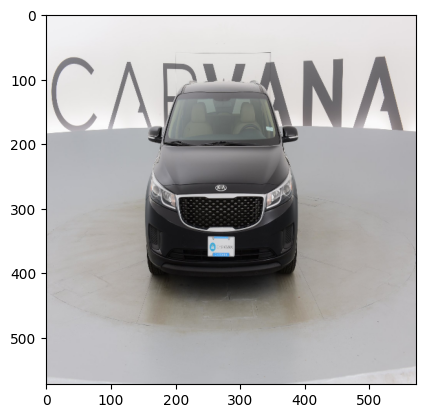

In [9]:
image, mask = train_data[12]
# Permute the dimensions from CHW to HWC for imshow
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.show()

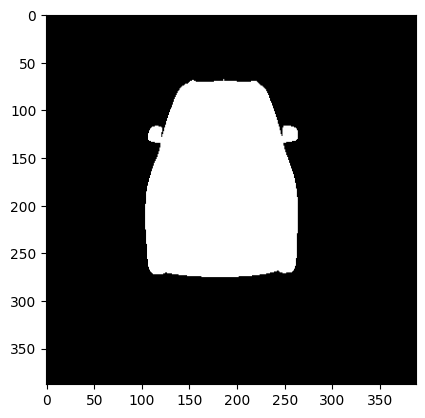

In [10]:
plt.imshow(mask[0], cmap='gray')

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features):
        super().__init__()
        self.en1 = self.block(in_channels, features)
        self.en2 = self.block(features, features*2)
        self.en3 = self.block(features*2, features*4)
        self.en4 = self.block(features*4, features*8)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc = self.block(features*8, features*16)
        
        self.up4 = nn.ConvTranspose2d(features*16, features*8, 2, 2, 0)
        self.de4 = self.block(features*16, features*8)
        self.up3 = nn.ConvTranspose2d(features*8, features*4, 2, 2, 0)
        self.de3 = self.block(features*8, features*4)
        self.up2 = nn.ConvTranspose2d(features*4, features*2, 2, 2, 0)
        self.de2 = self.block(features*4, features*2)
        self.up1 = nn.ConvTranspose2d(features*2, features, 2, 2, 0)
        self.de1 = self.block(features*2, features)
        
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
        
#         self.softmax = nn.Softmax(dim=1)
        self.initialize_weights()
        
    def block(self, in_channels, out_channels):
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride = 1, padding = 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride = 1, padding = 0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())
        return self.layer
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
    
    def forward(self, x):
        en1 = self.en1(x)
        en1_pooled = self.pool(en1)
        en2 = self.en2(en1_pooled)
        en2_pooled = self.pool(en2)
        en3 = self.en3(en2_pooled)
        en3_pooled = self.pool(en3)
        en4 = self.en4(en3_pooled)
        en4_pooled = self.pool(en4)
        fc = self.fc(en4_pooled)
        de4 = self.up4(fc)
        en4_cropped = TF.crop(en4, (en4.size(2) - de4.size(2)) // 2, (en4.size(3) - de4.size(3)) // 2, de4.size(2), de4.size(3))
        de4 = torch.cat([de4, en4_cropped], dim = 1)
        de4 = self.de4(de4)
        de3 = self.up3(de4)
        en3_cropped = TF.crop(en3, (en3.size(2) - de3.size(2)) // 2, (en3.size(3) - de3.size(3)) // 2, de3.size(2), de3.size(3))
        de3 = torch.cat([de3, en3_cropped], dim = 1)
        de3 = self.de3(de3)
        de2 = self.up2(de3)
        en2_cropped = TF.crop(en2, (en2.size(2) - de2.size(2)) // 2, (en2.size(3) - de2.size(3)) // 2, de2.size(2), de2.size(3))
        de2 = torch.cat([de2, en2_cropped], dim = 1)
        de2 = self.de2(de2)
        de1 = self.up1(de2)
        en1_cropped = TF.crop(en1, (en1.size(2) - de1.size(2)) // 2, (en1.size(3) - de1.size(3)) // 2, de1.size(2), de1.size(3))
        de1 = torch.cat([de1, en1_cropped], dim = 1)
        de1 = self.de1(de1)
        out = self.conv(de1)
#         out = self.softmax(out)
        return out

In [12]:
# x = torch.randn(1, 3, 572, 572)
# model = UNet(3, 1, 64).to(device)
# y = model(x)
# print(y.shape)

In [13]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)       
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [14]:
model = UNet(in_channels, out_channels, features).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = DiceBCELoss()
# model.load_state_dict(torch.load("/kaggle/working/model_UNet.pth"))

In [15]:
checkpoint_dir_UNet = '/kaggle/working/checkpoints_UNet'
os.makedirs(checkpoint_dir_UNet, exist_ok=True)

In [16]:
start_epoch, t_loss = load_checkpoint(model, optimizer, checkpoint_dir_UNet)
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (image, mask) in enumerate(train_loader):
        image = image.to(device)
        mask = mask.float().to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, mask)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= len(train_loader)
    t_loss.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}')
    save_checkpoint(epoch, model, optimizer, t_loss, checkpoint_dir_UNet)

Epoch 1, Train Loss: 0.3763672319809908
Checkpoint Saved at epoch1
Epoch 2, Train Loss: 0.21265694578059297
Checkpoint Saved at epoch2
Epoch 3, Train Loss: 0.18037322276292006
Checkpoint Saved at epoch3
Epoch 4, Train Loss: 0.16028401084346716
Checkpoint Saved at epoch4
Epoch 5, Train Loss: 0.149885733888168
Checkpoint Saved at epoch5
Epoch 6, Train Loss: 0.13709527646394515
Checkpoint Saved at epoch6
Epoch 7, Train Loss: 0.1278487955364591
Checkpoint Saved at epoch7
Epoch 8, Train Loss: 0.11782331748596578
Checkpoint Saved at epoch8
Epoch 9, Train Loss: 0.11198188966114535
Checkpoint Saved at epoch9
Epoch 10, Train Loss: 0.10484647774274784
Checkpoint Saved at epoch10
Epoch 11, Train Loss: 0.09788453037354707
Checkpoint Saved at epoch11
Epoch 12, Train Loss: 0.0926325309780117
Checkpoint Saved at epoch12
Epoch 13, Train Loss: 0.08770015860646085
Checkpoint Saved at epoch13
Epoch 14, Train Loss: 0.08324259713526325
Checkpoint Saved at epoch14
Epoch 15, Train Loss: 0.07809112545227255
C

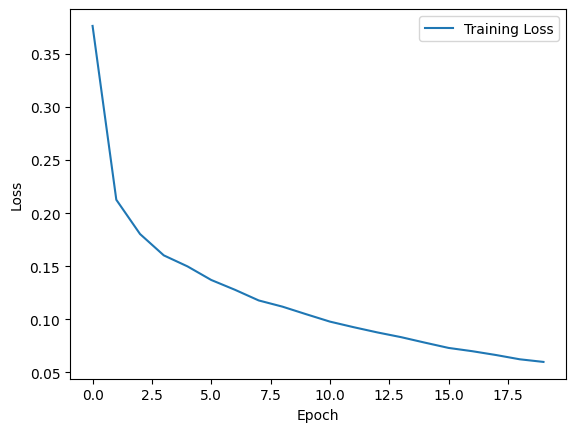

In [21]:
plt.plot(t_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

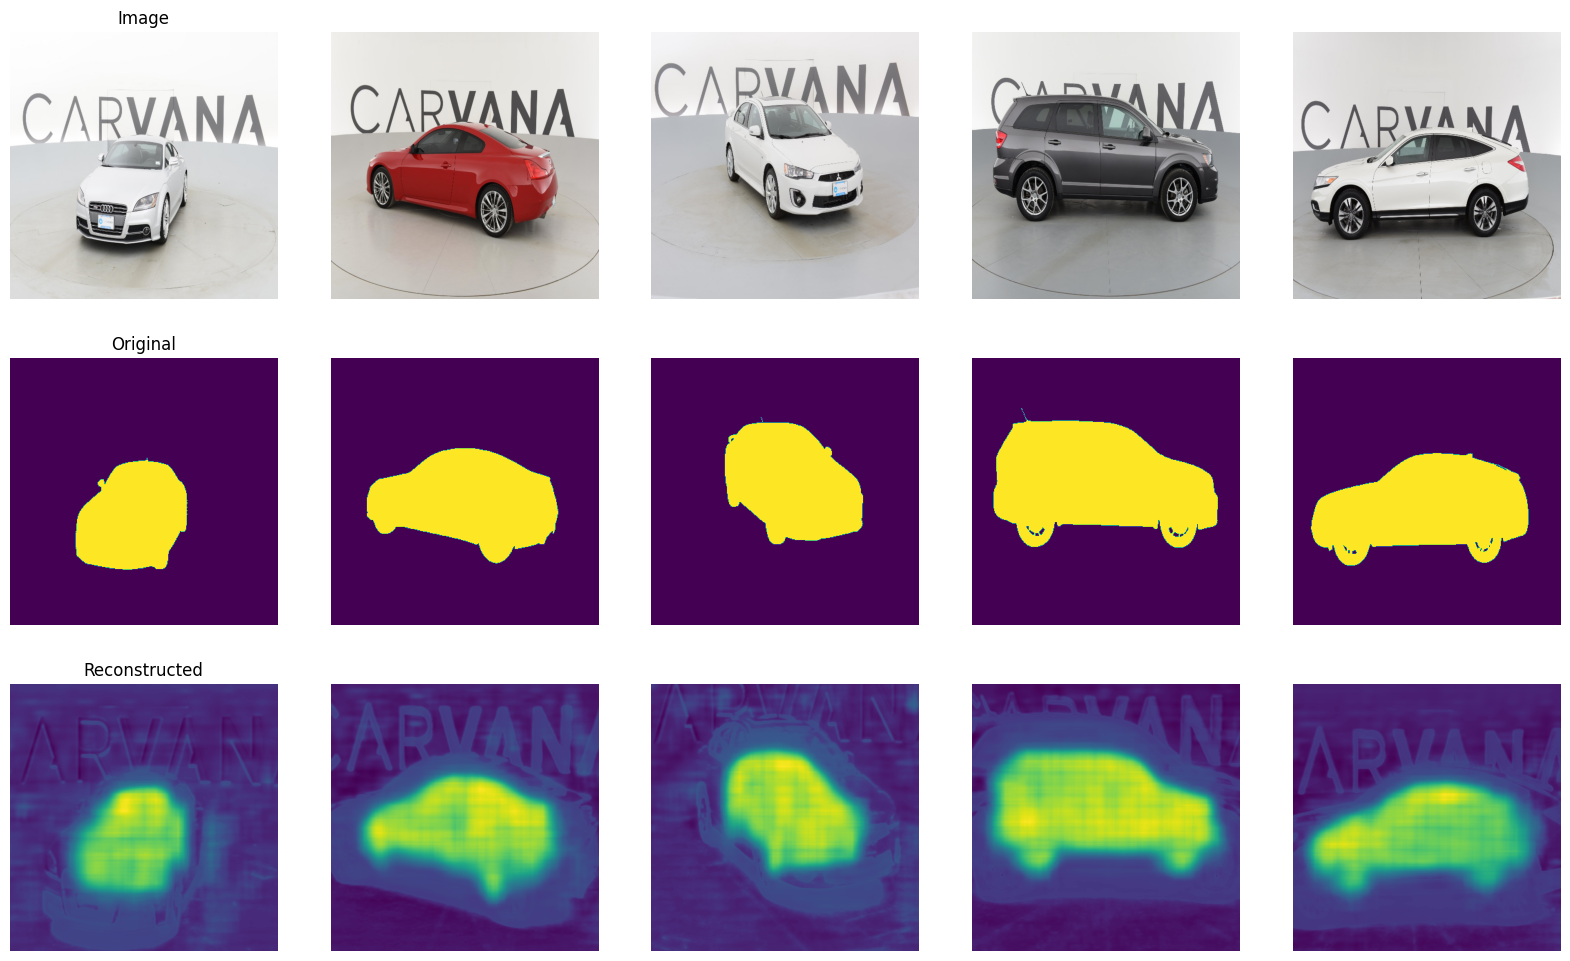

In [17]:
data = next(iter(val_loader))
images = data[0].to(device)
masks = data[1].to(device)

model.eval()
output = model(image)

fig, ax = plt.subplots(3, 5, figsize=(20, 12))
ax[0, 0].set_title("Image")
ax[1, 0].set_title("Original")
ax[2, 0].set_title("Reconstructed")
for i in range(5):
    ax[0, i].imshow(image[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[1, i].imshow(mask[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[2, i].imshow(output[i].permute(1, 2, 0).cpu().detach().numpy())
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
plt.show()